# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

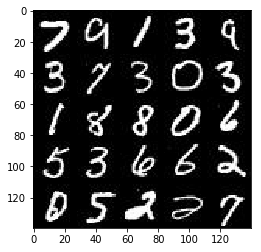

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

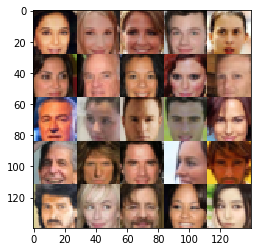

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='input')
    z = tf.placeholder(tf.float32,(None,z_dim),name='z')
    lr = tf.placeholder(tf.float32,name='lr')
    
    return input_, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        alpha=0.2
        
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images,64,5,strides=2,padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = leaky_relu(x, alpha=0.2, name='leaky_relu')
        
        # 14*14*64
        x2 = tf.layers.conv2d(x,128,5,strides=2,padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = leaky_relu(x2, alpha=0.2, name='leaky_relu')
        
        # 7*7*128
        x3 = tf.layers.conv2d(x2,256,5,strides=2,padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = leaky_relu(x3, alpha=0.2, name='leaky_relu')
                              
        flat = tf.reshape(x3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        
        out = tf.sigmoid(logits)

    return (logits, out)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train) as scope:
        
        alpha = 0.2
        
        # First fully connectedlayer
        x1 =  tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha=0.2, name='leaky_relu')
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha=0.2, name='leaky_relu')
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim,5,strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z,out_channel_dim)
    d_logits_real, d_model_real = discriminator(input_real)
    d_logits_fake, d_model_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)* (1.0 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
     # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    steps = 0

    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], "RGB")               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 3.5997
Epoch 1/2... Discriminator Loss: 3.2051... Generator Loss: 0.1630
Epoch 1/2... Discriminator Loss: 2.1897... Generator Loss: 4.0018
Epoch 1/2... Discriminator Loss: 1.7908... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 1.5114
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.6216... Generator Loss: 1.7473
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 0.5326


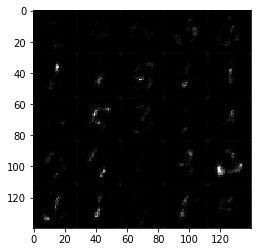

Epoch 1/2... Discriminator Loss: 2.1679... Generator Loss: 0.2167
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 1.2958
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.4064
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 1.4689


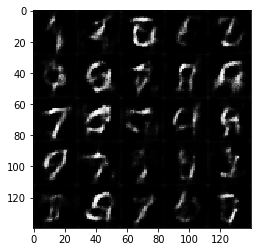

Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 1.2364
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.5351
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 1.5324
Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.6391


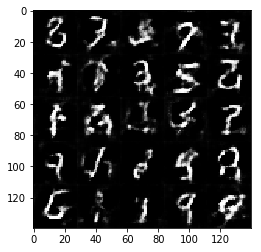

Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 1.5676
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.8476
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 1.8088
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6353


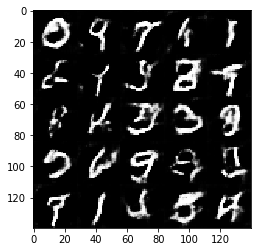

Epoch 1/2... Discriminator Loss: 1.6709... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 1.0881
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.0386
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.8173... Generator Loss: 0.3044


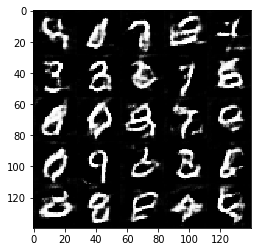

Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.2390
Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 1.6462... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 1.7875
Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 1.5165


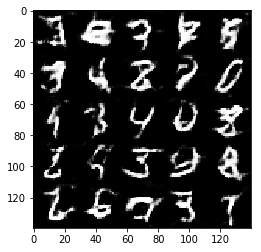

Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.6482
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.4294
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.5100
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.2238


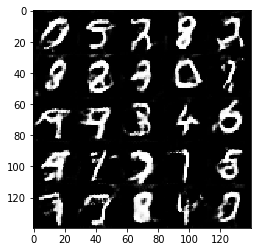

Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 1.7481... Generator Loss: 0.3388
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 0.9685... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.6925... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.6453... Generator Loss: 1.9706
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 1.2376


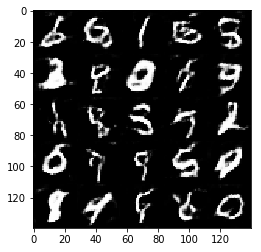

Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.2705
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 1.5661
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 1.0106
Epoch 1/2... Discriminator Loss: 1.1599... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.1638
Epoch 1/2... Discriminator Loss: 1.8601... Generator Loss: 0.3225
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 1.4083


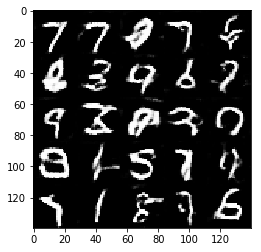

Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.6502
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.5865
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 1.1588
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.8321


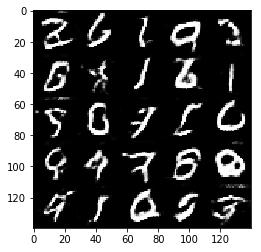

Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.0022
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 1.4158
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.1858


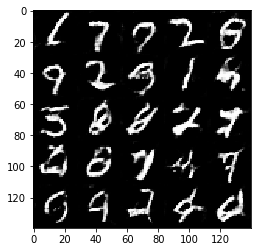

Epoch 1/2... Discriminator Loss: 1.6897... Generator Loss: 0.4124
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 1.8741
Epoch 1/2... Discriminator Loss: 2.6518... Generator Loss: 3.2110
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 1.5214
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.0510
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.7426


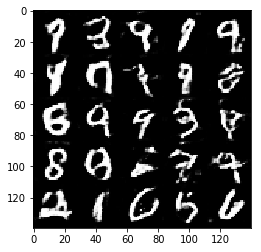

Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.6255
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.6747
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.1921


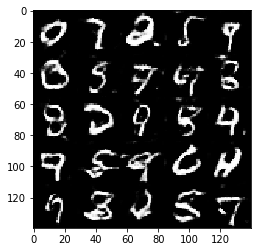

Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.7444
Epoch 1/2... Discriminator Loss: 1.7877... Generator Loss: 0.4181
Epoch 1/2... Discriminator Loss: 0.6927... Generator Loss: 1.6532
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.3223
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 2.4210


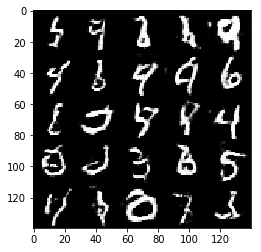

Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.8568
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.9339
Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 1.3141
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.5707
Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 1.6838... Generator Loss: 0.3944
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.8188


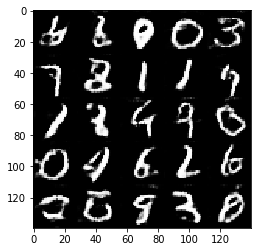

Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 2.2041
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 1.5697
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.9115
Epoch 1/2... Discriminator Loss: 0.5753... Generator Loss: 1.9930
Epoch 1/2... Discriminator Loss: 0.6440... Generator Loss: 1.9582
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.5661


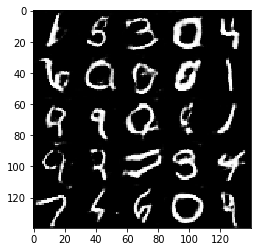

Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.5992
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.1274
Epoch 1/2... Discriminator Loss: 2.1428... Generator Loss: 0.3063
Epoch 1/2... Discriminator Loss: 0.7571... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 1.4423
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 3.0550
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.8686
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.7430


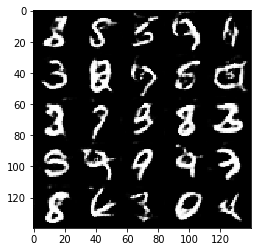

Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 1.4716
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.6665
Epoch 1/2... Discriminator Loss: 1.6652... Generator Loss: 2.6130
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.7841
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.4430
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.4446


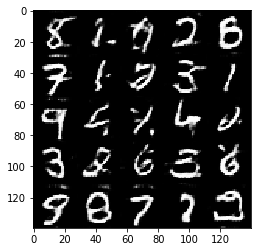

Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 0.8856
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.1874
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 0.6168
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.5972
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.3844
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.6967
Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.9144


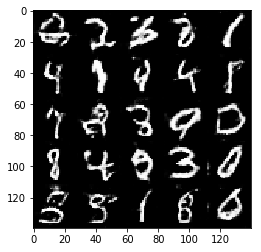

Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.4149
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 2.6181
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 2.2862
Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 1.5303
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 1.7365
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.3643
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.4142


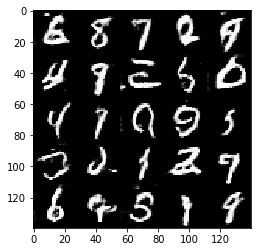

Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 2.5876
Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 1.3326
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.9282
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.7753


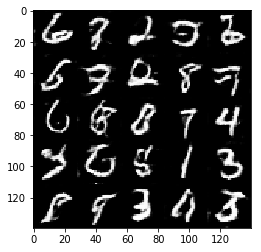

Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.6922
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.8396
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 0.7907... Generator Loss: 1.2554
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 2.2647
Epoch 2/2... Discriminator Loss: 0.5647... Generator Loss: 1.8768


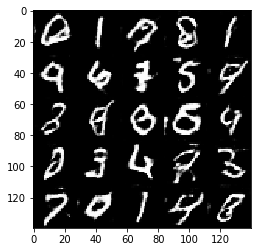

Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.5359
Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 1.6503
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.8575
Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.8086
Epoch 2/2... Discriminator Loss: 0.7597... Generator Loss: 1.4573
Epoch 2/2... Discriminator Loss: 0.6284... Generator Loss: 2.1157
Epoch 2/2... Discriminator Loss: 0.4216... Generator Loss: 2.9021
Epoch 2/2... Discriminator Loss: 1.2987... Generator Loss: 3.6330


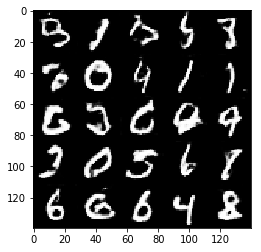

Epoch 2/2... Discriminator Loss: 2.0458... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 0.5509... Generator Loss: 2.2537
Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.7754
Epoch 2/2... Discriminator Loss: 0.5030... Generator Loss: 2.2055
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 2.5715... Generator Loss: 5.4734
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 1.4930... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 1.0077


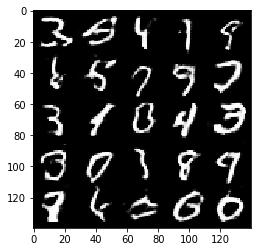

Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.7018
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.5149
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.6822
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 1.0338
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 0.7956... Generator Loss: 1.3555
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.6170


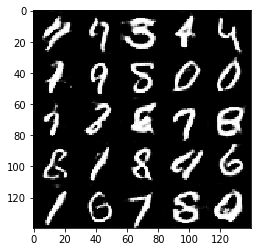

Epoch 2/2... Discriminator Loss: 2.0007... Generator Loss: 0.2816
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.9657
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.2149
Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 1.6035
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 3.3676
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.5418
Epoch 2/2... Discriminator Loss: 0.4975... Generator Loss: 2.2818
Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.5534


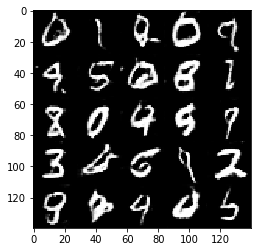

Epoch 2/2... Discriminator Loss: 0.6002... Generator Loss: 1.8268
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 1.6093
Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.5172
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 2.4501
Epoch 2/2... Discriminator Loss: 0.5308... Generator Loss: 2.2142
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 0.4733... Generator Loss: 3.0929
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 1.3182
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 2.9208


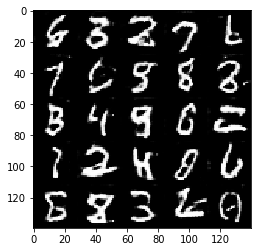

Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 2.3200
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 1.8495
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 2.2513
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.6988
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 2.5621
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 3.7185
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 2.3080
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.7311
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 2.3130
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 2.4642


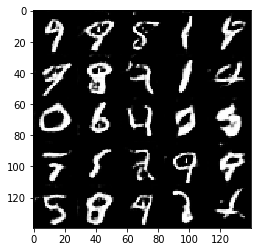

Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 2.1612
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 1.9862
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 1.7026
Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 2.8596
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 2.6094
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.3512
Epoch 2/2... Discriminator Loss: 0.6166... Generator Loss: 1.6910
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 2.0962
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.6357


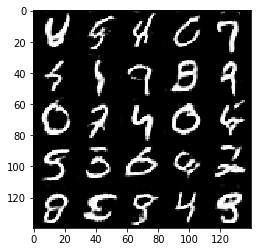

Epoch 2/2... Discriminator Loss: 1.9558... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 2.5456
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 0.7221... Generator Loss: 1.3636
Epoch 2/2... Discriminator Loss: 2.0135... Generator Loss: 0.3903
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 3.2489
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 1.1029
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.6234
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.9471


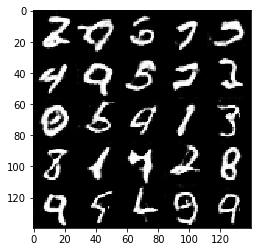

Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 2.3737
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.5799
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 2.6657
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.6205
Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 1.6065
Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 2.9653


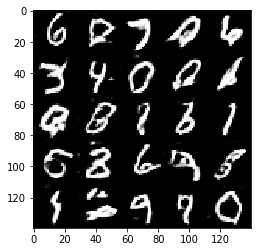

Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 1.8976
Epoch 2/2... Discriminator Loss: 1.5331... Generator Loss: 0.5499
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 2.9436
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 2.1554
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 2.6211
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 2.1335
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 2.2213
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.6822


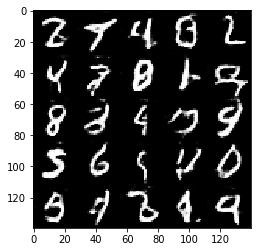

Epoch 2/2... Discriminator Loss: 1.6787... Generator Loss: 0.5019
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 3.5722
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 1.5342
Epoch 2/2... Discriminator Loss: 1.5808... Generator Loss: 0.4746
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.3081
Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 2.5112
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.5170
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 1.4411
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.3678


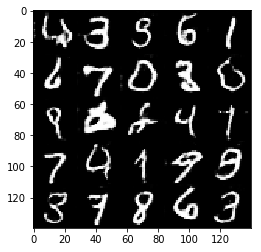

Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 0.4644... Generator Loss: 2.4508
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 1.9270... Generator Loss: 0.3700
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.3246
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.4950
Epoch 2/2... Discriminator Loss: 0.6173... Generator Loss: 1.7877
Epoch 2/2... Discriminator Loss: 0.6191... Generator Loss: 1.7947
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 2.1282
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.6355


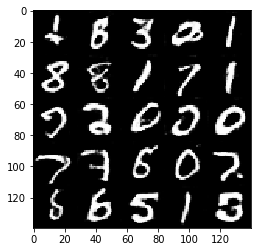

Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.7915
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.4619
Epoch 2/2... Discriminator Loss: 2.4260... Generator Loss: 6.9783
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 2.0153
Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 0.5194... Generator Loss: 2.0956
Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.6165


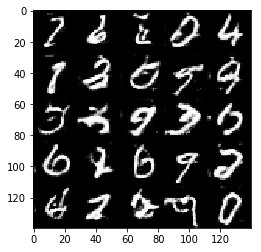

Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 2.2336
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.5826
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.3578
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.6730
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.4664
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 2.8772
Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 1.8748
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.5907
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.4476


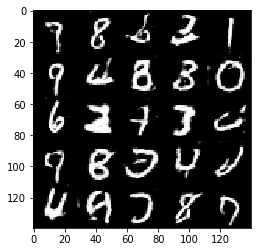

Epoch 2/2... Discriminator Loss: 0.5522... Generator Loss: 2.1079
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.3430
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 0.7705... Generator Loss: 1.2949
Epoch 2/2... Discriminator Loss: 0.5904... Generator Loss: 2.0337
Epoch 2/2... Discriminator Loss: 0.9299... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.9616
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 2.0447


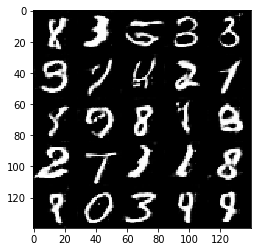

Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 2.2549
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.7695
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 2.1348


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 0.7180... Generator Loss: 1.8665
Epoch 1/5... Discriminator Loss: 1.2377... Generator Loss: 0.6226
Epoch 1/5... Discriminator Loss: 1.5962... Generator Loss: 0.4538
Epoch 1/5... Discriminator Loss: 1.0298... Generator Loss: 0.8412
Epoch 1/5... Discriminator Loss: 1.3500... Generator Loss: 0.6909
Epoch 1/5... Discriminator Loss: 1.4124... Generator Loss: 0.5320
Epoch 1/5... Discriminator Loss: 1.6843... Generator Loss: 1.5012
Epoch 1/5... Discriminator Loss: 0.9770... Generator Loss: 0.9022
Epoch 1/5... Discriminator Loss: 1.1993... Generator Loss: 2.3144
Epoch 1/5... Discriminator Loss: 1.0380... Generator Loss: 0.7899


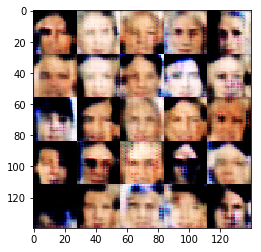

Epoch 1/5... Discriminator Loss: 1.9841... Generator Loss: 0.2581
Epoch 1/5... Discriminator Loss: 0.9686... Generator Loss: 1.4555
Epoch 1/5... Discriminator Loss: 1.2098... Generator Loss: 0.9807
Epoch 1/5... Discriminator Loss: 1.3204... Generator Loss: 0.8198
Epoch 1/5... Discriminator Loss: 0.7106... Generator Loss: 1.4517
Epoch 1/5... Discriminator Loss: 1.3998... Generator Loss: 0.7172
Epoch 1/5... Discriminator Loss: 1.4223... Generator Loss: 0.7939
Epoch 1/5... Discriminator Loss: 1.1770... Generator Loss: 0.8691
Epoch 1/5... Discriminator Loss: 1.4651... Generator Loss: 0.7433
Epoch 1/5... Discriminator Loss: 1.4259... Generator Loss: 0.5543


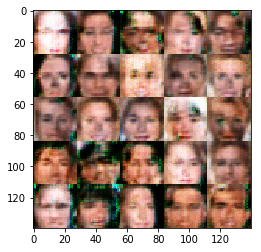

Epoch 1/5... Discriminator Loss: 1.5279... Generator Loss: 1.9479
Epoch 1/5... Discriminator Loss: 1.3290... Generator Loss: 0.5862
Epoch 1/5... Discriminator Loss: 1.2791... Generator Loss: 0.8566
Epoch 1/5... Discriminator Loss: 1.2054... Generator Loss: 0.8359
Epoch 1/5... Discriminator Loss: 1.0914... Generator Loss: 1.0455
Epoch 1/5... Discriminator Loss: 1.2457... Generator Loss: 1.3762
Epoch 1/5... Discriminator Loss: 1.3940... Generator Loss: 0.9067
Epoch 1/5... Discriminator Loss: 1.1732... Generator Loss: 0.7881
Epoch 1/5... Discriminator Loss: 1.3590... Generator Loss: 0.6867
Epoch 1/5... Discriminator Loss: 1.4089... Generator Loss: 0.5071


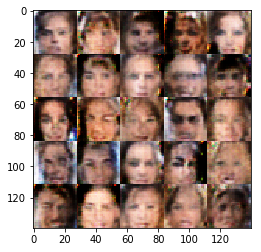

Epoch 1/5... Discriminator Loss: 1.0169... Generator Loss: 1.2448
Epoch 1/5... Discriminator Loss: 1.2170... Generator Loss: 0.6570
Epoch 1/5... Discriminator Loss: 1.9595... Generator Loss: 0.3084
Epoch 1/5... Discriminator Loss: 1.0471... Generator Loss: 1.5407
Epoch 1/5... Discriminator Loss: 1.4876... Generator Loss: 1.3909
Epoch 1/5... Discriminator Loss: 1.1048... Generator Loss: 0.9699
Epoch 1/5... Discriminator Loss: 1.3306... Generator Loss: 1.0572
Epoch 1/5... Discriminator Loss: 0.7658... Generator Loss: 1.1180
Epoch 1/5... Discriminator Loss: 1.4058... Generator Loss: 0.9396
Epoch 1/5... Discriminator Loss: 1.2409... Generator Loss: 1.2687


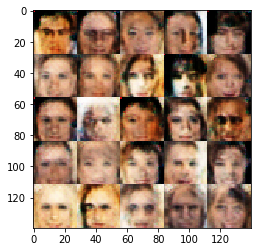

Epoch 1/5... Discriminator Loss: 0.9652... Generator Loss: 1.2780
Epoch 1/5... Discriminator Loss: 1.3525... Generator Loss: 0.7048
Epoch 1/5... Discriminator Loss: 0.7226... Generator Loss: 1.3705
Epoch 1/5... Discriminator Loss: 1.3016... Generator Loss: 0.9115
Epoch 1/5... Discriminator Loss: 1.4057... Generator Loss: 0.8072
Epoch 1/5... Discriminator Loss: 1.3633... Generator Loss: 0.7790
Epoch 1/5... Discriminator Loss: 1.3670... Generator Loss: 0.8111
Epoch 1/5... Discriminator Loss: 1.3355... Generator Loss: 0.7956
Epoch 1/5... Discriminator Loss: 1.3353... Generator Loss: 0.8525
Epoch 1/5... Discriminator Loss: 1.2551... Generator Loss: 0.8897


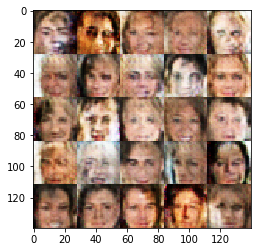

Epoch 1/5... Discriminator Loss: 1.4652... Generator Loss: 0.7256
Epoch 1/5... Discriminator Loss: 1.3913... Generator Loss: 0.8739
Epoch 1/5... Discriminator Loss: 1.3885... Generator Loss: 0.7699
Epoch 1/5... Discriminator Loss: 1.3879... Generator Loss: 0.7707
Epoch 1/5... Discriminator Loss: 1.2923... Generator Loss: 0.7990
Epoch 1/5... Discriminator Loss: 1.2696... Generator Loss: 0.8673
Epoch 1/5... Discriminator Loss: 1.3325... Generator Loss: 0.7721
Epoch 1/5... Discriminator Loss: 1.2504... Generator Loss: 0.8213
Epoch 1/5... Discriminator Loss: 1.3851... Generator Loss: 0.7604
Epoch 1/5... Discriminator Loss: 1.4308... Generator Loss: 0.6699


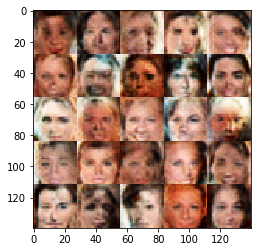

Epoch 1/5... Discriminator Loss: 1.3241... Generator Loss: 1.2145
Epoch 1/5... Discriminator Loss: 1.4338... Generator Loss: 0.7878
Epoch 1/5... Discriminator Loss: 1.3709... Generator Loss: 0.7249
Epoch 1/5... Discriminator Loss: 1.3311... Generator Loss: 0.8949
Epoch 1/5... Discriminator Loss: 1.2477... Generator Loss: 0.9588
Epoch 1/5... Discriminator Loss: 1.4087... Generator Loss: 0.5948
Epoch 1/5... Discriminator Loss: 1.4046... Generator Loss: 0.5806
Epoch 1/5... Discriminator Loss: 1.3650... Generator Loss: 0.6899
Epoch 1/5... Discriminator Loss: 1.2532... Generator Loss: 0.8966
Epoch 1/5... Discriminator Loss: 1.7180... Generator Loss: 1.8077


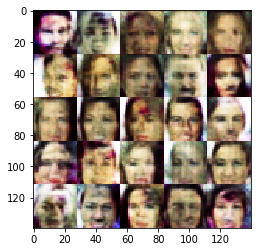

Epoch 1/5... Discriminator Loss: 1.3937... Generator Loss: 0.5725
Epoch 1/5... Discriminator Loss: 1.3693... Generator Loss: 0.7990
Epoch 1/5... Discriminator Loss: 1.3830... Generator Loss: 0.9698
Epoch 1/5... Discriminator Loss: 1.2761... Generator Loss: 0.8929
Epoch 1/5... Discriminator Loss: 1.3440... Generator Loss: 0.7475
Epoch 1/5... Discriminator Loss: 1.3980... Generator Loss: 0.6961
Epoch 1/5... Discriminator Loss: 1.4073... Generator Loss: 0.8173
Epoch 1/5... Discriminator Loss: 1.2962... Generator Loss: 0.6742
Epoch 1/5... Discriminator Loss: 1.3562... Generator Loss: 0.6535
Epoch 1/5... Discriminator Loss: 1.3539... Generator Loss: 1.0657


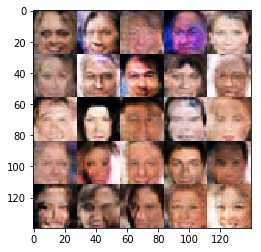

Epoch 1/5... Discriminator Loss: 1.3677... Generator Loss: 0.6320
Epoch 1/5... Discriminator Loss: 1.3803... Generator Loss: 0.6930
Epoch 1/5... Discriminator Loss: 1.4142... Generator Loss: 0.5471
Epoch 1/5... Discriminator Loss: 1.2635... Generator Loss: 0.8918
Epoch 1/5... Discriminator Loss: 1.4744... Generator Loss: 0.6166
Epoch 1/5... Discriminator Loss: 1.3099... Generator Loss: 0.6862
Epoch 1/5... Discriminator Loss: 1.2964... Generator Loss: 0.7370
Epoch 1/5... Discriminator Loss: 1.1730... Generator Loss: 0.7860
Epoch 1/5... Discriminator Loss: 1.3383... Generator Loss: 0.7246
Epoch 1/5... Discriminator Loss: 1.3677... Generator Loss: 0.6293


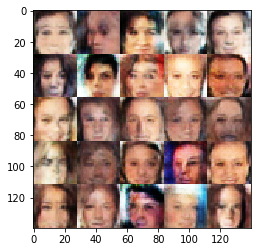

Epoch 1/5... Discriminator Loss: 1.1552... Generator Loss: 0.8839
Epoch 1/5... Discriminator Loss: 1.3096... Generator Loss: 0.7828
Epoch 1/5... Discriminator Loss: 1.3053... Generator Loss: 1.2783
Epoch 1/5... Discriminator Loss: 1.4236... Generator Loss: 0.6497
Epoch 1/5... Discriminator Loss: 1.3156... Generator Loss: 0.7055
Epoch 1/5... Discriminator Loss: 1.2613... Generator Loss: 0.8997
Epoch 1/5... Discriminator Loss: 1.3387... Generator Loss: 0.7727
Epoch 1/5... Discriminator Loss: 1.2415... Generator Loss: 0.7885
Epoch 1/5... Discriminator Loss: 1.3443... Generator Loss: 1.1176
Epoch 1/5... Discriminator Loss: 1.3031... Generator Loss: 0.7980


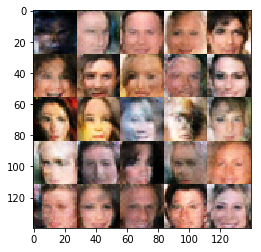

Epoch 1/5... Discriminator Loss: 1.1649... Generator Loss: 1.1376
Epoch 1/5... Discriminator Loss: 1.2086... Generator Loss: 0.8663
Epoch 1/5... Discriminator Loss: 1.3220... Generator Loss: 0.8842
Epoch 1/5... Discriminator Loss: 1.2865... Generator Loss: 0.9575
Epoch 1/5... Discriminator Loss: 1.2459... Generator Loss: 0.8942
Epoch 1/5... Discriminator Loss: 1.3330... Generator Loss: 0.7372
Epoch 1/5... Discriminator Loss: 1.2984... Generator Loss: 0.7862
Epoch 1/5... Discriminator Loss: 1.4629... Generator Loss: 0.4884
Epoch 1/5... Discriminator Loss: 1.2727... Generator Loss: 0.9200
Epoch 1/5... Discriminator Loss: 1.2761... Generator Loss: 0.7490


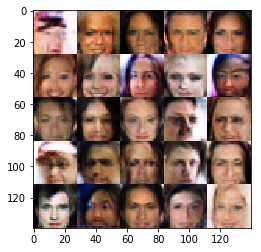

Epoch 1/5... Discriminator Loss: 1.2692... Generator Loss: 0.7993
Epoch 1/5... Discriminator Loss: 0.8342... Generator Loss: 1.5396
Epoch 1/5... Discriminator Loss: 1.4487... Generator Loss: 0.6003
Epoch 1/5... Discriminator Loss: 1.3393... Generator Loss: 0.7653
Epoch 1/5... Discriminator Loss: 1.3255... Generator Loss: 0.9222
Epoch 1/5... Discriminator Loss: 1.2573... Generator Loss: 0.7796
Epoch 1/5... Discriminator Loss: 1.3830... Generator Loss: 0.7026
Epoch 1/5... Discriminator Loss: 1.3534... Generator Loss: 0.7069
Epoch 1/5... Discriminator Loss: 1.3463... Generator Loss: 0.8235
Epoch 1/5... Discriminator Loss: 1.2520... Generator Loss: 0.8090


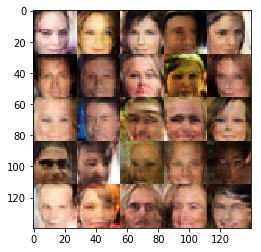

Epoch 1/5... Discriminator Loss: 1.3571... Generator Loss: 0.6935
Epoch 1/5... Discriminator Loss: 1.4015... Generator Loss: 0.7226
Epoch 1/5... Discriminator Loss: 1.3466... Generator Loss: 0.8768
Epoch 1/5... Discriminator Loss: 1.3747... Generator Loss: 0.5313
Epoch 1/5... Discriminator Loss: 1.2447... Generator Loss: 0.7806
Epoch 1/5... Discriminator Loss: 1.2533... Generator Loss: 0.7208
Epoch 2/5... Discriminator Loss: 1.2368... Generator Loss: 0.8841
Epoch 2/5... Discriminator Loss: 1.3364... Generator Loss: 0.9206
Epoch 2/5... Discriminator Loss: 1.3935... Generator Loss: 0.6110
Epoch 2/5... Discriminator Loss: 1.3643... Generator Loss: 0.7381


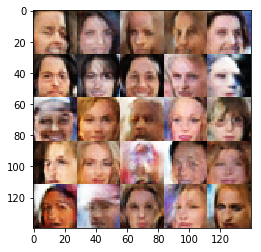

Epoch 2/5... Discriminator Loss: 1.3592... Generator Loss: 0.6042
Epoch 2/5... Discriminator Loss: 1.3822... Generator Loss: 0.7617
Epoch 2/5... Discriminator Loss: 1.2914... Generator Loss: 0.8167
Epoch 2/5... Discriminator Loss: 1.3201... Generator Loss: 0.8913
Epoch 2/5... Discriminator Loss: 1.2946... Generator Loss: 0.8131
Epoch 2/5... Discriminator Loss: 1.3508... Generator Loss: 0.7393
Epoch 2/5... Discriminator Loss: 1.2904... Generator Loss: 0.9395
Epoch 2/5... Discriminator Loss: 1.3142... Generator Loss: 0.9580
Epoch 2/5... Discriminator Loss: 1.4512... Generator Loss: 0.5957
Epoch 2/5... Discriminator Loss: 1.1793... Generator Loss: 0.8467


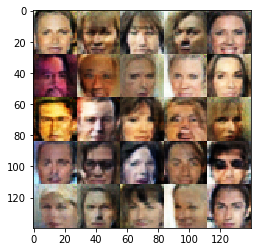

Epoch 2/5... Discriminator Loss: 1.4123... Generator Loss: 0.7536
Epoch 2/5... Discriminator Loss: 1.3786... Generator Loss: 0.5953
Epoch 2/5... Discriminator Loss: 1.4346... Generator Loss: 0.5968
Epoch 2/5... Discriminator Loss: 1.3788... Generator Loss: 0.7187
Epoch 2/5... Discriminator Loss: 1.0356... Generator Loss: 1.4257
Epoch 2/5... Discriminator Loss: 1.3018... Generator Loss: 0.7384
Epoch 2/5... Discriminator Loss: 1.2563... Generator Loss: 0.7987
Epoch 2/5... Discriminator Loss: 1.3925... Generator Loss: 0.7910
Epoch 2/5... Discriminator Loss: 1.2997... Generator Loss: 0.8084
Epoch 2/5... Discriminator Loss: 1.3360... Generator Loss: 0.7878


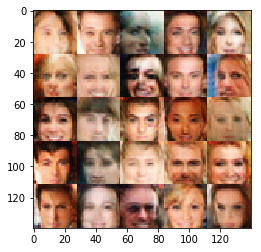

Epoch 2/5... Discriminator Loss: 1.3651... Generator Loss: 0.9000
Epoch 2/5... Discriminator Loss: 1.3397... Generator Loss: 0.6997
Epoch 2/5... Discriminator Loss: 1.2337... Generator Loss: 0.7825
Epoch 2/5... Discriminator Loss: 1.3441... Generator Loss: 0.7370
Epoch 2/5... Discriminator Loss: 1.1671... Generator Loss: 0.8019
Epoch 2/5... Discriminator Loss: 1.2205... Generator Loss: 0.9217
Epoch 2/5... Discriminator Loss: 1.4118... Generator Loss: 0.7760
Epoch 2/5... Discriminator Loss: 1.2868... Generator Loss: 0.8778
Epoch 2/5... Discriminator Loss: 1.2542... Generator Loss: 0.7553
Epoch 2/5... Discriminator Loss: 1.2190... Generator Loss: 0.9158


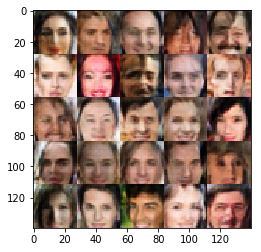

Epoch 2/5... Discriminator Loss: 1.2939... Generator Loss: 0.7820
Epoch 2/5... Discriminator Loss: 1.3040... Generator Loss: 0.6709
Epoch 2/5... Discriminator Loss: 1.2715... Generator Loss: 0.7856
Epoch 2/5... Discriminator Loss: 1.3230... Generator Loss: 0.6944
Epoch 2/5... Discriminator Loss: 1.3634... Generator Loss: 0.6114
Epoch 2/5... Discriminator Loss: 1.3229... Generator Loss: 0.7486
Epoch 2/5... Discriminator Loss: 1.2708... Generator Loss: 0.7500
Epoch 2/5... Discriminator Loss: 1.4341... Generator Loss: 0.6647
Epoch 2/5... Discriminator Loss: 1.3065... Generator Loss: 0.7245
Epoch 2/5... Discriminator Loss: 1.2056... Generator Loss: 1.0370


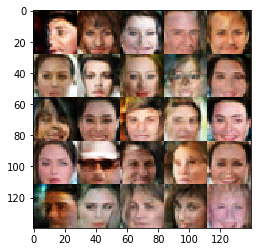

Epoch 2/5... Discriminator Loss: 1.2819... Generator Loss: 0.6778
Epoch 2/5... Discriminator Loss: 1.0490... Generator Loss: 1.0685
Epoch 2/5... Discriminator Loss: 1.3484... Generator Loss: 0.6031
Epoch 2/5... Discriminator Loss: 1.3323... Generator Loss: 0.7131
Epoch 2/5... Discriminator Loss: 1.2997... Generator Loss: 0.8395
Epoch 2/5... Discriminator Loss: 1.4483... Generator Loss: 0.6975
Epoch 2/5... Discriminator Loss: 1.2299... Generator Loss: 0.7662
Epoch 2/5... Discriminator Loss: 1.2593... Generator Loss: 0.8416
Epoch 2/5... Discriminator Loss: 1.3702... Generator Loss: 0.6637
Epoch 2/5... Discriminator Loss: 1.2688... Generator Loss: 0.7796


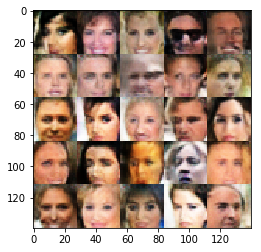

Epoch 2/5... Discriminator Loss: 1.2534... Generator Loss: 0.8165
Epoch 2/5... Discriminator Loss: 1.2858... Generator Loss: 0.7955
Epoch 2/5... Discriminator Loss: 1.4478... Generator Loss: 0.5193
Epoch 2/5... Discriminator Loss: 1.2541... Generator Loss: 0.7472
Epoch 2/5... Discriminator Loss: 1.3889... Generator Loss: 0.7221
Epoch 2/5... Discriminator Loss: 1.3651... Generator Loss: 0.6795
Epoch 2/5... Discriminator Loss: 1.3374... Generator Loss: 0.6828
Epoch 2/5... Discriminator Loss: 1.3532... Generator Loss: 0.6185
Epoch 2/5... Discriminator Loss: 1.2908... Generator Loss: 0.7596
Epoch 2/5... Discriminator Loss: 1.3320... Generator Loss: 0.6993


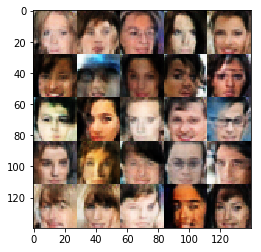

Epoch 2/5... Discriminator Loss: 1.3087... Generator Loss: 0.7261
Epoch 2/5... Discriminator Loss: 1.1705... Generator Loss: 0.9288
Epoch 2/5... Discriminator Loss: 1.3863... Generator Loss: 0.6356
Epoch 2/5... Discriminator Loss: 1.2507... Generator Loss: 0.8956
Epoch 2/5... Discriminator Loss: 1.5304... Generator Loss: 0.5139
Epoch 2/5... Discriminator Loss: 1.1966... Generator Loss: 0.8066
Epoch 2/5... Discriminator Loss: 1.2680... Generator Loss: 0.7593
Epoch 2/5... Discriminator Loss: 1.3332... Generator Loss: 0.6248
Epoch 2/5... Discriminator Loss: 1.1720... Generator Loss: 0.8896
Epoch 2/5... Discriminator Loss: 1.3229... Generator Loss: 0.6004


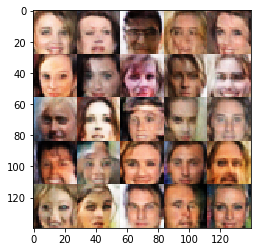

Epoch 2/5... Discriminator Loss: 1.2885... Generator Loss: 0.7243
Epoch 2/5... Discriminator Loss: 1.3012... Generator Loss: 0.6862
Epoch 2/5... Discriminator Loss: 1.3493... Generator Loss: 0.6275
Epoch 2/5... Discriminator Loss: 1.3552... Generator Loss: 0.6502
Epoch 2/5... Discriminator Loss: 1.3763... Generator Loss: 0.6259
Epoch 2/5... Discriminator Loss: 1.0873... Generator Loss: 0.9300
Epoch 2/5... Discriminator Loss: 1.3474... Generator Loss: 0.7297
Epoch 2/5... Discriminator Loss: 1.2712... Generator Loss: 0.9060
Epoch 2/5... Discriminator Loss: 1.3080... Generator Loss: 0.7397
Epoch 2/5... Discriminator Loss: 1.2492... Generator Loss: 0.7453


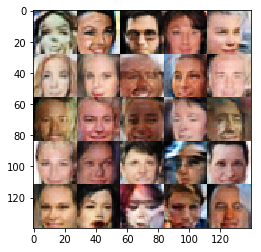

Epoch 2/5... Discriminator Loss: 1.2602... Generator Loss: 0.8708
Epoch 2/5... Discriminator Loss: 1.2968... Generator Loss: 0.6953
Epoch 2/5... Discriminator Loss: 1.3801... Generator Loss: 0.6092
Epoch 2/5... Discriminator Loss: 1.3319... Generator Loss: 0.6616
Epoch 2/5... Discriminator Loss: 1.2931... Generator Loss: 0.8561
Epoch 2/5... Discriminator Loss: 1.3429... Generator Loss: 0.7111
Epoch 2/5... Discriminator Loss: 1.2295... Generator Loss: 0.7706
Epoch 2/5... Discriminator Loss: 1.2013... Generator Loss: 0.7527
Epoch 2/5... Discriminator Loss: 1.2187... Generator Loss: 0.8849
Epoch 2/5... Discriminator Loss: 1.4042... Generator Loss: 0.5724


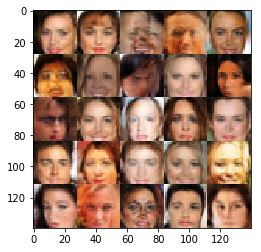

Epoch 2/5... Discriminator Loss: 1.2553... Generator Loss: 0.7855
Epoch 2/5... Discriminator Loss: 1.1674... Generator Loss: 0.8522
Epoch 2/5... Discriminator Loss: 1.3852... Generator Loss: 0.6928
Epoch 2/5... Discriminator Loss: 1.0793... Generator Loss: 0.9001
Epoch 2/5... Discriminator Loss: 1.3174... Generator Loss: 0.6622
Epoch 2/5... Discriminator Loss: 1.3016... Generator Loss: 0.8451
Epoch 2/5... Discriminator Loss: 1.2761... Generator Loss: 0.6797
Epoch 2/5... Discriminator Loss: 1.1563... Generator Loss: 0.9247
Epoch 2/5... Discriminator Loss: 1.4060... Generator Loss: 0.5944
Epoch 2/5... Discriminator Loss: 1.2882... Generator Loss: 0.7251


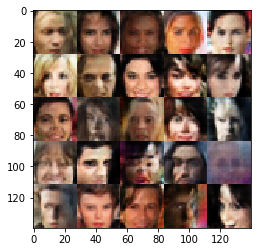

Epoch 2/5... Discriminator Loss: 1.0795... Generator Loss: 0.9425
Epoch 2/5... Discriminator Loss: 1.1471... Generator Loss: 0.8298
Epoch 2/5... Discriminator Loss: 1.1899... Generator Loss: 0.7267
Epoch 2/5... Discriminator Loss: 1.3462... Generator Loss: 0.7072
Epoch 2/5... Discriminator Loss: 1.1979... Generator Loss: 0.6831
Epoch 2/5... Discriminator Loss: 1.3182... Generator Loss: 0.6022
Epoch 2/5... Discriminator Loss: 1.2761... Generator Loss: 0.8591
Epoch 2/5... Discriminator Loss: 1.2668... Generator Loss: 0.6779
Epoch 2/5... Discriminator Loss: 1.1789... Generator Loss: 0.7353
Epoch 2/5... Discriminator Loss: 1.4104... Generator Loss: 0.5381


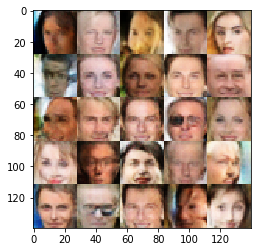

Epoch 2/5... Discriminator Loss: 1.2933... Generator Loss: 0.6221
Epoch 2/5... Discriminator Loss: 1.2866... Generator Loss: 0.9384
Epoch 2/5... Discriminator Loss: 1.2759... Generator Loss: 0.7742
Epoch 2/5... Discriminator Loss: 1.0996... Generator Loss: 0.8762
Epoch 2/5... Discriminator Loss: 1.6177... Generator Loss: 0.4799
Epoch 2/5... Discriminator Loss: 1.3235... Generator Loss: 0.7458
Epoch 2/5... Discriminator Loss: 1.1788... Generator Loss: 1.1043
Epoch 2/5... Discriminator Loss: 1.2549... Generator Loss: 0.7579
Epoch 2/5... Discriminator Loss: 1.4524... Generator Loss: 0.5117
Epoch 2/5... Discriminator Loss: 1.2268... Generator Loss: 0.7732


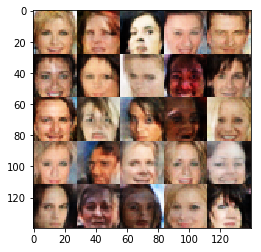

Epoch 2/5... Discriminator Loss: 1.4537... Generator Loss: 0.5375
Epoch 2/5... Discriminator Loss: 1.2557... Generator Loss: 0.7113
Epoch 2/5... Discriminator Loss: 1.2490... Generator Loss: 0.8286
Epoch 3/5... Discriminator Loss: 1.0013... Generator Loss: 0.9201
Epoch 3/5... Discriminator Loss: 1.3907... Generator Loss: 0.5567
Epoch 3/5... Discriminator Loss: 1.2226... Generator Loss: 0.7022
Epoch 3/5... Discriminator Loss: 1.1338... Generator Loss: 0.8927
Epoch 3/5... Discriminator Loss: 1.2165... Generator Loss: 0.8071
Epoch 3/5... Discriminator Loss: 1.2571... Generator Loss: 0.7620
Epoch 3/5... Discriminator Loss: 1.2675... Generator Loss: 0.6966


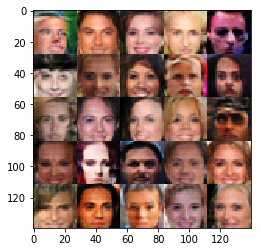

Epoch 3/5... Discriminator Loss: 1.2325... Generator Loss: 0.7572
Epoch 3/5... Discriminator Loss: 1.1538... Generator Loss: 0.7521
Epoch 3/5... Discriminator Loss: 1.1444... Generator Loss: 1.0666
Epoch 3/5... Discriminator Loss: 1.1844... Generator Loss: 0.7904
Epoch 3/5... Discriminator Loss: 1.3084... Generator Loss: 0.7141
Epoch 3/5... Discriminator Loss: 1.2250... Generator Loss: 0.7167
Epoch 3/5... Discriminator Loss: 1.2808... Generator Loss: 0.7037
Epoch 3/5... Discriminator Loss: 1.3804... Generator Loss: 0.6646
Epoch 3/5... Discriminator Loss: 1.1564... Generator Loss: 0.7906
Epoch 3/5... Discriminator Loss: 1.4106... Generator Loss: 0.6753


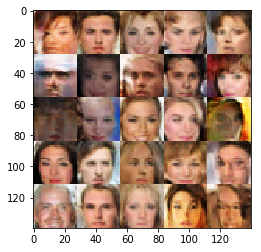

Epoch 3/5... Discriminator Loss: 1.1643... Generator Loss: 0.9222
Epoch 3/5... Discriminator Loss: 1.2775... Generator Loss: 0.7038
Epoch 3/5... Discriminator Loss: 1.3524... Generator Loss: 0.9920
Epoch 3/5... Discriminator Loss: 1.3748... Generator Loss: 0.5452
Epoch 3/5... Discriminator Loss: 1.2421... Generator Loss: 0.8335
Epoch 3/5... Discriminator Loss: 1.3548... Generator Loss: 0.5357
Epoch 3/5... Discriminator Loss: 1.0781... Generator Loss: 0.8122
Epoch 3/5... Discriminator Loss: 1.2819... Generator Loss: 0.6229
Epoch 3/5... Discriminator Loss: 1.2610... Generator Loss: 0.7624
Epoch 3/5... Discriminator Loss: 0.9302... Generator Loss: 1.3374


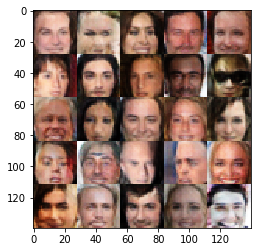

Epoch 3/5... Discriminator Loss: 1.3333... Generator Loss: 0.6034
Epoch 3/5... Discriminator Loss: 1.1353... Generator Loss: 0.9005
Epoch 3/5... Discriminator Loss: 1.2388... Generator Loss: 0.6907
Epoch 3/5... Discriminator Loss: 1.1955... Generator Loss: 0.7722
Epoch 3/5... Discriminator Loss: 1.1456... Generator Loss: 0.8776
Epoch 3/5... Discriminator Loss: 1.3058... Generator Loss: 0.9302
Epoch 3/5... Discriminator Loss: 1.2527... Generator Loss: 0.7898
Epoch 3/5... Discriminator Loss: 1.2106... Generator Loss: 0.7309
Epoch 3/5... Discriminator Loss: 1.3195... Generator Loss: 0.6298
Epoch 3/5... Discriminator Loss: 1.2082... Generator Loss: 0.9454


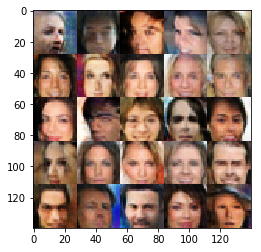

Epoch 3/5... Discriminator Loss: 1.1517... Generator Loss: 1.0953
Epoch 3/5... Discriminator Loss: 1.2461... Generator Loss: 0.6947
Epoch 3/5... Discriminator Loss: 1.2799... Generator Loss: 0.8162
Epoch 3/5... Discriminator Loss: 1.4822... Generator Loss: 0.4696
Epoch 3/5... Discriminator Loss: 1.0041... Generator Loss: 0.9621
Epoch 3/5... Discriminator Loss: 1.1738... Generator Loss: 1.0190
Epoch 3/5... Discriminator Loss: 1.0719... Generator Loss: 1.1189
Epoch 3/5... Discriminator Loss: 1.4201... Generator Loss: 0.5835
Epoch 3/5... Discriminator Loss: 1.1867... Generator Loss: 0.7656
Epoch 3/5... Discriminator Loss: 1.2925... Generator Loss: 0.7076


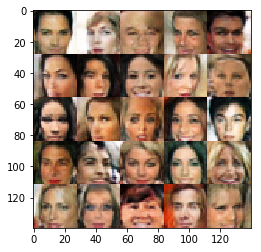

Epoch 3/5... Discriminator Loss: 1.0717... Generator Loss: 0.9041
Epoch 3/5... Discriminator Loss: 1.0955... Generator Loss: 0.9167
Epoch 3/5... Discriminator Loss: 1.2006... Generator Loss: 0.7165
Epoch 3/5... Discriminator Loss: 1.2256... Generator Loss: 0.6993
Epoch 3/5... Discriminator Loss: 1.1250... Generator Loss: 0.8316
Epoch 3/5... Discriminator Loss: 1.1653... Generator Loss: 0.8002
Epoch 3/5... Discriminator Loss: 1.2583... Generator Loss: 0.5895
Epoch 3/5... Discriminator Loss: 1.0867... Generator Loss: 0.8278
Epoch 3/5... Discriminator Loss: 1.0859... Generator Loss: 1.3022
Epoch 3/5... Discriminator Loss: 1.2200... Generator Loss: 0.7307


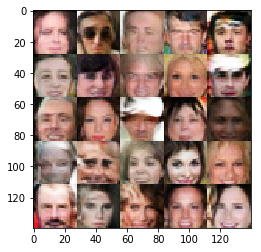

Epoch 3/5... Discriminator Loss: 1.3278... Generator Loss: 0.5903
Epoch 3/5... Discriminator Loss: 1.0420... Generator Loss: 0.9168
Epoch 3/5... Discriminator Loss: 1.1949... Generator Loss: 0.7877
Epoch 3/5... Discriminator Loss: 1.1122... Generator Loss: 0.8700
Epoch 3/5... Discriminator Loss: 1.0989... Generator Loss: 1.3072
Epoch 3/5... Discriminator Loss: 1.1996... Generator Loss: 0.8073
Epoch 3/5... Discriminator Loss: 1.2835... Generator Loss: 0.6139
Epoch 3/5... Discriminator Loss: 1.4498... Generator Loss: 0.4809
Epoch 3/5... Discriminator Loss: 1.2850... Generator Loss: 0.6621
Epoch 3/5... Discriminator Loss: 1.3285... Generator Loss: 0.5615


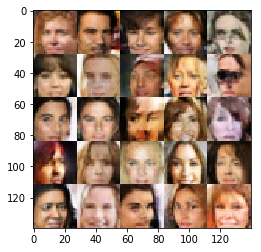

Epoch 3/5... Discriminator Loss: 1.0151... Generator Loss: 1.0481
Epoch 3/5... Discriminator Loss: 1.1166... Generator Loss: 0.8048
Epoch 3/5... Discriminator Loss: 1.2141... Generator Loss: 0.6901
Epoch 3/5... Discriminator Loss: 0.8407... Generator Loss: 1.1472
Epoch 3/5... Discriminator Loss: 1.3801... Generator Loss: 0.5142
Epoch 3/5... Discriminator Loss: 0.8574... Generator Loss: 1.0900
Epoch 3/5... Discriminator Loss: 0.9639... Generator Loss: 1.2319
Epoch 3/5... Discriminator Loss: 0.8528... Generator Loss: 1.0933
Epoch 3/5... Discriminator Loss: 1.1393... Generator Loss: 0.7873
Epoch 3/5... Discriminator Loss: 1.2680... Generator Loss: 0.6652


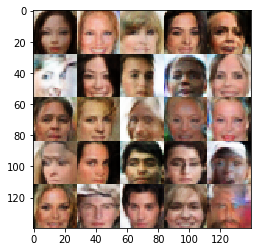

Epoch 3/5... Discriminator Loss: 1.4870... Generator Loss: 0.7315
Epoch 3/5... Discriminator Loss: 1.1945... Generator Loss: 0.7629
Epoch 3/5... Discriminator Loss: 0.8579... Generator Loss: 1.2970
Epoch 3/5... Discriminator Loss: 0.9087... Generator Loss: 1.0427
Epoch 3/5... Discriminator Loss: 1.4971... Generator Loss: 0.4297
Epoch 3/5... Discriminator Loss: 1.0563... Generator Loss: 0.8187
Epoch 3/5... Discriminator Loss: 1.0972... Generator Loss: 1.0993
Epoch 3/5... Discriminator Loss: 1.1711... Generator Loss: 0.7801
Epoch 3/5... Discriminator Loss: 1.0132... Generator Loss: 1.1112
Epoch 3/5... Discriminator Loss: 1.1313... Generator Loss: 0.8199


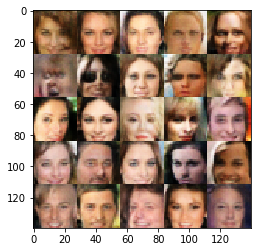

Epoch 3/5... Discriminator Loss: 1.6370... Generator Loss: 0.3935
Epoch 3/5... Discriminator Loss: 1.1704... Generator Loss: 0.6572
Epoch 3/5... Discriminator Loss: 1.0685... Generator Loss: 0.9116
Epoch 3/5... Discriminator Loss: 1.0299... Generator Loss: 0.9755
Epoch 3/5... Discriminator Loss: 1.2016... Generator Loss: 0.8416
Epoch 3/5... Discriminator Loss: 1.1725... Generator Loss: 0.9415
Epoch 3/5... Discriminator Loss: 0.9800... Generator Loss: 1.1129
Epoch 3/5... Discriminator Loss: 1.1625... Generator Loss: 0.8395
Epoch 3/5... Discriminator Loss: 1.4413... Generator Loss: 1.3327
Epoch 3/5... Discriminator Loss: 0.9950... Generator Loss: 0.9833


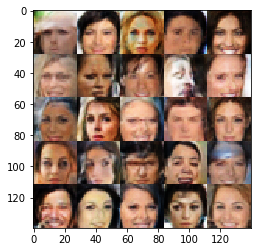

Epoch 3/5... Discriminator Loss: 1.1862... Generator Loss: 0.7922
Epoch 3/5... Discriminator Loss: 1.2820... Generator Loss: 0.6777
Epoch 3/5... Discriminator Loss: 0.9967... Generator Loss: 1.0367
Epoch 3/5... Discriminator Loss: 1.1101... Generator Loss: 0.9694
Epoch 3/5... Discriminator Loss: 1.2709... Generator Loss: 0.5508
Epoch 3/5... Discriminator Loss: 1.1580... Generator Loss: 0.8233
Epoch 3/5... Discriminator Loss: 0.9509... Generator Loss: 1.0468
Epoch 3/5... Discriminator Loss: 1.0523... Generator Loss: 1.0174
Epoch 3/5... Discriminator Loss: 1.1161... Generator Loss: 0.7630
Epoch 3/5... Discriminator Loss: 0.7681... Generator Loss: 1.4251


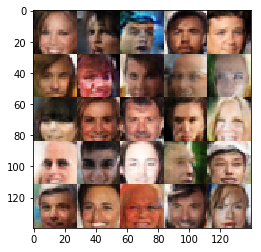

Epoch 3/5... Discriminator Loss: 1.2765... Generator Loss: 0.6157
Epoch 3/5... Discriminator Loss: 1.1567... Generator Loss: 0.6724
Epoch 3/5... Discriminator Loss: 1.1845... Generator Loss: 0.6131
Epoch 3/5... Discriminator Loss: 1.5461... Generator Loss: 0.3970
Epoch 3/5... Discriminator Loss: 1.1595... Generator Loss: 1.9645
Epoch 3/5... Discriminator Loss: 1.7309... Generator Loss: 0.3282
Epoch 3/5... Discriminator Loss: 1.0952... Generator Loss: 0.8272
Epoch 3/5... Discriminator Loss: 0.8363... Generator Loss: 1.2394
Epoch 3/5... Discriminator Loss: 1.2325... Generator Loss: 0.5925
Epoch 3/5... Discriminator Loss: 1.1530... Generator Loss: 0.7776


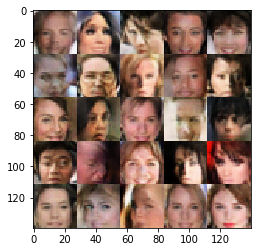

Epoch 3/5... Discriminator Loss: 0.8904... Generator Loss: 1.0441
Epoch 3/5... Discriminator Loss: 1.0701... Generator Loss: 0.8479
Epoch 3/5... Discriminator Loss: 1.1568... Generator Loss: 0.7303
Epoch 3/5... Discriminator Loss: 0.9352... Generator Loss: 1.5554
Epoch 3/5... Discriminator Loss: 1.3300... Generator Loss: 0.5853
Epoch 3/5... Discriminator Loss: 0.9286... Generator Loss: 1.1334
Epoch 3/5... Discriminator Loss: 1.3891... Generator Loss: 0.5053
Epoch 3/5... Discriminator Loss: 1.3737... Generator Loss: 0.5760
Epoch 3/5... Discriminator Loss: 1.2173... Generator Loss: 0.6377
Epoch 4/5... Discriminator Loss: 1.0616... Generator Loss: 0.8455


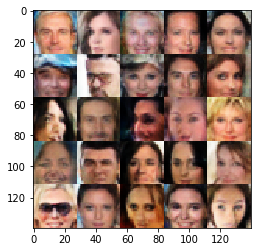

Epoch 4/5... Discriminator Loss: 1.0695... Generator Loss: 0.7991
Epoch 4/5... Discriminator Loss: 1.1353... Generator Loss: 1.5349
Epoch 4/5... Discriminator Loss: 1.0408... Generator Loss: 0.8519
Epoch 4/5... Discriminator Loss: 1.1147... Generator Loss: 0.7612
Epoch 4/5... Discriminator Loss: 1.1104... Generator Loss: 1.0532
Epoch 4/5... Discriminator Loss: 0.7820... Generator Loss: 1.5432
Epoch 4/5... Discriminator Loss: 1.2091... Generator Loss: 1.0684
Epoch 4/5... Discriminator Loss: 1.2696... Generator Loss: 0.6318
Epoch 4/5... Discriminator Loss: 1.3353... Generator Loss: 0.5406
Epoch 4/5... Discriminator Loss: 1.1367... Generator Loss: 0.6779


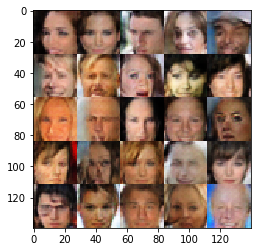

Epoch 4/5... Discriminator Loss: 1.2493... Generator Loss: 0.6606
Epoch 4/5... Discriminator Loss: 1.1913... Generator Loss: 0.6521
Epoch 4/5... Discriminator Loss: 0.9493... Generator Loss: 0.9827
Epoch 4/5... Discriminator Loss: 1.2694... Generator Loss: 0.6817
Epoch 4/5... Discriminator Loss: 0.9980... Generator Loss: 0.8677
Epoch 4/5... Discriminator Loss: 0.9043... Generator Loss: 0.9237
Epoch 4/5... Discriminator Loss: 0.7584... Generator Loss: 1.5266
Epoch 4/5... Discriminator Loss: 1.0932... Generator Loss: 0.7722
Epoch 4/5... Discriminator Loss: 1.1453... Generator Loss: 0.7106
Epoch 4/5... Discriminator Loss: 1.1029... Generator Loss: 1.0097


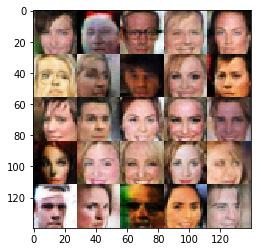

Epoch 4/5... Discriminator Loss: 0.9084... Generator Loss: 1.0073
Epoch 4/5... Discriminator Loss: 1.1257... Generator Loss: 0.9113
Epoch 4/5... Discriminator Loss: 0.9921... Generator Loss: 0.8509
Epoch 4/5... Discriminator Loss: 1.1749... Generator Loss: 0.7640
Epoch 4/5... Discriminator Loss: 1.0562... Generator Loss: 0.8060
Epoch 4/5... Discriminator Loss: 1.1100... Generator Loss: 0.9716
Epoch 4/5... Discriminator Loss: 1.1695... Generator Loss: 0.8740
Epoch 4/5... Discriminator Loss: 1.1406... Generator Loss: 0.8666
Epoch 4/5... Discriminator Loss: 1.0567... Generator Loss: 1.1318
Epoch 4/5... Discriminator Loss: 1.5611... Generator Loss: 0.4012


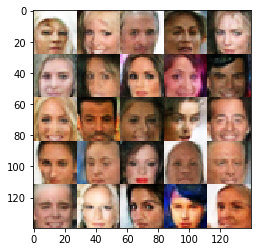

Epoch 4/5... Discriminator Loss: 0.9798... Generator Loss: 0.8702
Epoch 4/5... Discriminator Loss: 1.0279... Generator Loss: 0.7648
Epoch 4/5... Discriminator Loss: 1.4250... Generator Loss: 0.5294
Epoch 4/5... Discriminator Loss: 1.2295... Generator Loss: 0.6515
Epoch 4/5... Discriminator Loss: 0.7973... Generator Loss: 1.3014
Epoch 4/5... Discriminator Loss: 0.6754... Generator Loss: 1.5438
Epoch 4/5... Discriminator Loss: 0.8657... Generator Loss: 1.3234
Epoch 4/5... Discriminator Loss: 1.1154... Generator Loss: 0.7148
Epoch 4/5... Discriminator Loss: 1.3316... Generator Loss: 0.5661
Epoch 4/5... Discriminator Loss: 0.8306... Generator Loss: 1.5368


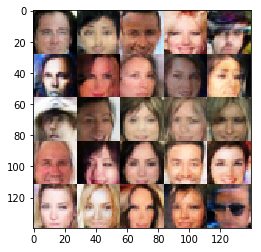

Epoch 4/5... Discriminator Loss: 1.5626... Generator Loss: 0.4001
Epoch 4/5... Discriminator Loss: 1.1167... Generator Loss: 0.7582
Epoch 4/5... Discriminator Loss: 1.1067... Generator Loss: 1.1863
Epoch 4/5... Discriminator Loss: 1.1906... Generator Loss: 0.6594
Epoch 4/5... Discriminator Loss: 1.2158... Generator Loss: 0.5982
Epoch 4/5... Discriminator Loss: 1.2508... Generator Loss: 0.6089
Epoch 4/5... Discriminator Loss: 0.8334... Generator Loss: 1.0797
Epoch 4/5... Discriminator Loss: 1.0860... Generator Loss: 0.8150
Epoch 4/5... Discriminator Loss: 0.9374... Generator Loss: 1.2555
Epoch 4/5... Discriminator Loss: 1.4475... Generator Loss: 0.4442


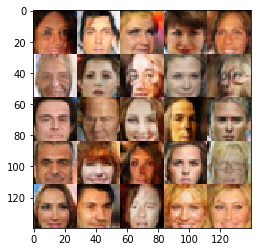

Epoch 4/5... Discriminator Loss: 0.9948... Generator Loss: 0.8736
Epoch 4/5... Discriminator Loss: 1.0064... Generator Loss: 1.0417
Epoch 4/5... Discriminator Loss: 0.9186... Generator Loss: 0.9569
Epoch 4/5... Discriminator Loss: 1.2147... Generator Loss: 0.5933
Epoch 4/5... Discriminator Loss: 1.0424... Generator Loss: 0.7790
Epoch 4/5... Discriminator Loss: 1.3330... Generator Loss: 0.5010
Epoch 4/5... Discriminator Loss: 0.8485... Generator Loss: 1.1432
Epoch 4/5... Discriminator Loss: 1.0015... Generator Loss: 0.9128
Epoch 4/5... Discriminator Loss: 0.9495... Generator Loss: 1.5481
Epoch 4/5... Discriminator Loss: 0.9915... Generator Loss: 1.1637


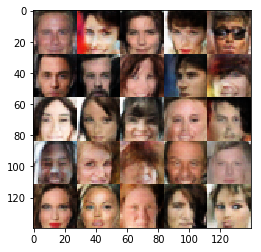

Epoch 4/5... Discriminator Loss: 1.1106... Generator Loss: 2.2590
Epoch 4/5... Discriminator Loss: 1.0250... Generator Loss: 0.9607
Epoch 4/5... Discriminator Loss: 1.0357... Generator Loss: 0.9170
Epoch 4/5... Discriminator Loss: 0.9723... Generator Loss: 1.0133
Epoch 4/5... Discriminator Loss: 1.5421... Generator Loss: 0.4068
Epoch 4/5... Discriminator Loss: 0.9791... Generator Loss: 1.0305
Epoch 4/5... Discriminator Loss: 1.2736... Generator Loss: 0.5408
Epoch 4/5... Discriminator Loss: 0.9511... Generator Loss: 0.9576
Epoch 4/5... Discriminator Loss: 0.9538... Generator Loss: 1.2897
Epoch 4/5... Discriminator Loss: 1.4559... Generator Loss: 0.4528


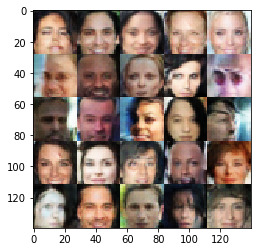

Epoch 4/5... Discriminator Loss: 1.1137... Generator Loss: 0.8742
Epoch 4/5... Discriminator Loss: 0.7628... Generator Loss: 1.4256
Epoch 4/5... Discriminator Loss: 1.0455... Generator Loss: 0.7853
Epoch 4/5... Discriminator Loss: 0.5828... Generator Loss: 1.8116
Epoch 4/5... Discriminator Loss: 0.8932... Generator Loss: 1.4041
Epoch 4/5... Discriminator Loss: 1.2029... Generator Loss: 0.6230
Epoch 4/5... Discriminator Loss: 1.0698... Generator Loss: 0.9388
Epoch 4/5... Discriminator Loss: 0.9525... Generator Loss: 0.9549
Epoch 4/5... Discriminator Loss: 1.0862... Generator Loss: 0.8478
Epoch 4/5... Discriminator Loss: 0.7500... Generator Loss: 2.2087


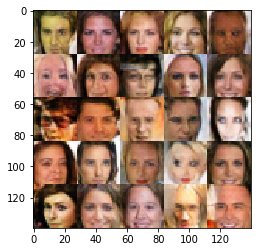

Epoch 4/5... Discriminator Loss: 0.9781... Generator Loss: 0.9888
Epoch 4/5... Discriminator Loss: 1.1352... Generator Loss: 1.0084
Epoch 4/5... Discriminator Loss: 0.9713... Generator Loss: 1.1461
Epoch 4/5... Discriminator Loss: 0.9784... Generator Loss: 0.9857
Epoch 4/5... Discriminator Loss: 1.2432... Generator Loss: 0.5984
Epoch 4/5... Discriminator Loss: 1.1833... Generator Loss: 0.6976
Epoch 4/5... Discriminator Loss: 1.0255... Generator Loss: 0.8807
Epoch 4/5... Discriminator Loss: 1.1522... Generator Loss: 0.6688
Epoch 4/5... Discriminator Loss: 1.1689... Generator Loss: 0.6423
Epoch 4/5... Discriminator Loss: 0.7843... Generator Loss: 1.2100


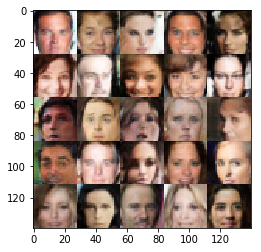

Epoch 4/5... Discriminator Loss: 0.9790... Generator Loss: 1.1395
Epoch 4/5... Discriminator Loss: 1.2492... Generator Loss: 1.6076
Epoch 4/5... Discriminator Loss: 1.3879... Generator Loss: 0.5132
Epoch 4/5... Discriminator Loss: 1.1007... Generator Loss: 0.7554
Epoch 4/5... Discriminator Loss: 1.3363... Generator Loss: 0.5554
Epoch 4/5... Discriminator Loss: 1.0775... Generator Loss: 1.0549
Epoch 4/5... Discriminator Loss: 0.9329... Generator Loss: 0.9815
Epoch 4/5... Discriminator Loss: 1.0037... Generator Loss: 0.9053
Epoch 4/5... Discriminator Loss: 1.1465... Generator Loss: 0.7085
Epoch 4/5... Discriminator Loss: 0.9147... Generator Loss: 1.1666


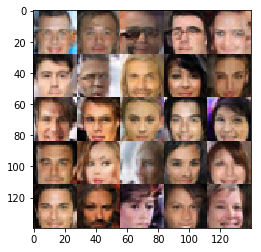

Epoch 4/5... Discriminator Loss: 0.8179... Generator Loss: 1.1338
Epoch 4/5... Discriminator Loss: 0.8471... Generator Loss: 1.2931
Epoch 4/5... Discriminator Loss: 0.9316... Generator Loss: 1.1513
Epoch 4/5... Discriminator Loss: 0.7239... Generator Loss: 1.3630
Epoch 4/5... Discriminator Loss: 1.2270... Generator Loss: 0.6187
Epoch 4/5... Discriminator Loss: 0.6973... Generator Loss: 1.5136
Epoch 4/5... Discriminator Loss: 0.8604... Generator Loss: 1.0814
Epoch 4/5... Discriminator Loss: 1.2363... Generator Loss: 0.5759
Epoch 4/5... Discriminator Loss: 1.1671... Generator Loss: 0.6920
Epoch 4/5... Discriminator Loss: 1.3428... Generator Loss: 0.5465


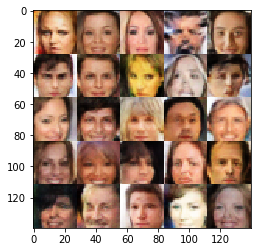

Epoch 4/5... Discriminator Loss: 0.9045... Generator Loss: 1.1014
Epoch 4/5... Discriminator Loss: 0.9603... Generator Loss: 0.8437
Epoch 4/5... Discriminator Loss: 0.8183... Generator Loss: 1.1509
Epoch 4/5... Discriminator Loss: 1.0121... Generator Loss: 1.2325
Epoch 4/5... Discriminator Loss: 0.8660... Generator Loss: 1.2274
Epoch 4/5... Discriminator Loss: 0.8700... Generator Loss: 1.0325
Epoch 4/5... Discriminator Loss: 1.1019... Generator Loss: 0.7484
Epoch 4/5... Discriminator Loss: 1.0524... Generator Loss: 0.9855
Epoch 4/5... Discriminator Loss: 1.0675... Generator Loss: 2.1356
Epoch 4/5... Discriminator Loss: 1.1661... Generator Loss: 1.9257


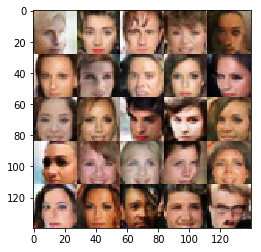

Epoch 4/5... Discriminator Loss: 0.9639... Generator Loss: 1.1245
Epoch 4/5... Discriminator Loss: 1.4898... Generator Loss: 0.4091
Epoch 4/5... Discriminator Loss: 1.0247... Generator Loss: 0.8668
Epoch 4/5... Discriminator Loss: 1.5208... Generator Loss: 0.4213
Epoch 4/5... Discriminator Loss: 0.8862... Generator Loss: 0.9859
Epoch 4/5... Discriminator Loss: 0.7003... Generator Loss: 1.7030
Epoch 5/5... Discriminator Loss: 1.4744... Generator Loss: 0.4373
Epoch 5/5... Discriminator Loss: 0.7003... Generator Loss: 1.5367
Epoch 5/5... Discriminator Loss: 1.0873... Generator Loss: 1.1326
Epoch 5/5... Discriminator Loss: 0.5714... Generator Loss: 1.8540


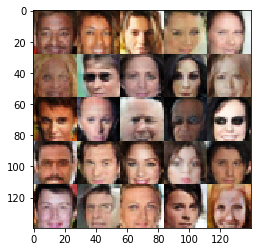

Epoch 5/5... Discriminator Loss: 0.8288... Generator Loss: 1.0570
Epoch 5/5... Discriminator Loss: 1.7124... Generator Loss: 0.3622
Epoch 5/5... Discriminator Loss: 1.1605... Generator Loss: 0.7522
Epoch 5/5... Discriminator Loss: 1.1754... Generator Loss: 0.6589
Epoch 5/5... Discriminator Loss: 1.1988... Generator Loss: 0.8189
Epoch 5/5... Discriminator Loss: 0.7975... Generator Loss: 1.3720
Epoch 5/5... Discriminator Loss: 0.9571... Generator Loss: 0.9517
Epoch 5/5... Discriminator Loss: 1.2260... Generator Loss: 0.6876
Epoch 5/5... Discriminator Loss: 0.9539... Generator Loss: 0.8772
Epoch 5/5... Discriminator Loss: 0.9134... Generator Loss: 1.4622


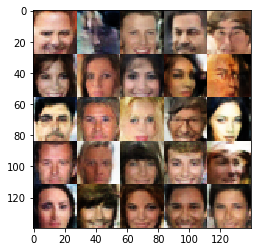

Epoch 5/5... Discriminator Loss: 0.5825... Generator Loss: 1.8300
Epoch 5/5... Discriminator Loss: 0.7586... Generator Loss: 1.4603
Epoch 5/5... Discriminator Loss: 1.5743... Generator Loss: 0.3943
Epoch 5/5... Discriminator Loss: 1.3920... Generator Loss: 0.4937
Epoch 5/5... Discriminator Loss: 1.5587... Generator Loss: 0.4090
Epoch 5/5... Discriminator Loss: 0.9867... Generator Loss: 0.8447
Epoch 5/5... Discriminator Loss: 0.8652... Generator Loss: 1.1115
Epoch 5/5... Discriminator Loss: 0.8132... Generator Loss: 1.8724
Epoch 5/5... Discriminator Loss: 1.0759... Generator Loss: 0.8035
Epoch 5/5... Discriminator Loss: 0.9897... Generator Loss: 0.8822


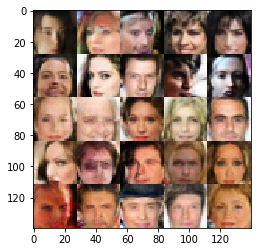

Epoch 5/5... Discriminator Loss: 1.0874... Generator Loss: 0.7501
Epoch 5/5... Discriminator Loss: 1.2505... Generator Loss: 0.5755
Epoch 5/5... Discriminator Loss: 1.0824... Generator Loss: 0.7289
Epoch 5/5... Discriminator Loss: 1.0401... Generator Loss: 0.8346
Epoch 5/5... Discriminator Loss: 1.2093... Generator Loss: 1.4071
Epoch 5/5... Discriminator Loss: 0.6648... Generator Loss: 1.5331
Epoch 5/5... Discriminator Loss: 0.6480... Generator Loss: 1.7951
Epoch 5/5... Discriminator Loss: 1.4104... Generator Loss: 0.4808
Epoch 5/5... Discriminator Loss: 0.7701... Generator Loss: 1.7824
Epoch 5/5... Discriminator Loss: 1.0854... Generator Loss: 0.7712


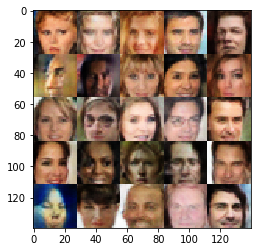

Epoch 5/5... Discriminator Loss: 1.1212... Generator Loss: 1.0621
Epoch 5/5... Discriminator Loss: 0.7778... Generator Loss: 1.4506
Epoch 5/5... Discriminator Loss: 0.6462... Generator Loss: 1.4116
Epoch 5/5... Discriminator Loss: 1.5720... Generator Loss: 0.4100
Epoch 5/5... Discriminator Loss: 0.8850... Generator Loss: 1.7465
Epoch 5/5... Discriminator Loss: 0.7955... Generator Loss: 1.1052
Epoch 5/5... Discriminator Loss: 1.1711... Generator Loss: 0.6657
Epoch 5/5... Discriminator Loss: 1.1100... Generator Loss: 0.8104
Epoch 5/5... Discriminator Loss: 1.0011... Generator Loss: 1.3046
Epoch 5/5... Discriminator Loss: 0.8880... Generator Loss: 1.2171


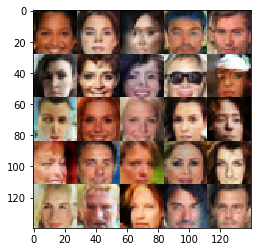

Epoch 5/5... Discriminator Loss: 1.4282... Generator Loss: 0.4799
Epoch 5/5... Discriminator Loss: 0.9496... Generator Loss: 0.8495
Epoch 5/5... Discriminator Loss: 1.0345... Generator Loss: 1.8366
Epoch 5/5... Discriminator Loss: 0.8495... Generator Loss: 1.2519
Epoch 5/5... Discriminator Loss: 0.6998... Generator Loss: 1.3548
Epoch 5/5... Discriminator Loss: 0.6611... Generator Loss: 1.5556
Epoch 5/5... Discriminator Loss: 1.0038... Generator Loss: 1.3075
Epoch 5/5... Discriminator Loss: 1.0282... Generator Loss: 2.0310
Epoch 5/5... Discriminator Loss: 1.3582... Generator Loss: 0.5526
Epoch 5/5... Discriminator Loss: 1.7080... Generator Loss: 0.3552


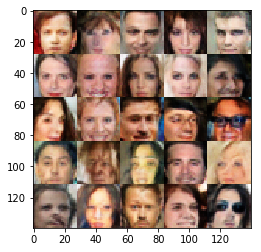

Epoch 5/5... Discriminator Loss: 1.3116... Generator Loss: 0.6337
Epoch 5/5... Discriminator Loss: 0.7799... Generator Loss: 1.1345
Epoch 5/5... Discriminator Loss: 0.9648... Generator Loss: 1.0690
Epoch 5/5... Discriminator Loss: 1.0523... Generator Loss: 0.7908
Epoch 5/5... Discriminator Loss: 0.6233... Generator Loss: 1.6761
Epoch 5/5... Discriminator Loss: 0.5367... Generator Loss: 2.3675
Epoch 5/5... Discriminator Loss: 0.8987... Generator Loss: 1.6453
Epoch 5/5... Discriminator Loss: 0.6840... Generator Loss: 1.7797
Epoch 5/5... Discriminator Loss: 1.0709... Generator Loss: 0.7391
Epoch 5/5... Discriminator Loss: 1.1381... Generator Loss: 0.7600


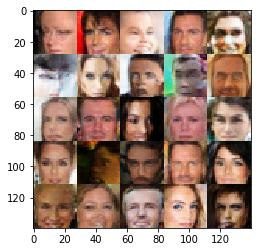

Epoch 5/5... Discriminator Loss: 0.9544... Generator Loss: 0.9304
Epoch 5/5... Discriminator Loss: 1.2927... Generator Loss: 0.6178
Epoch 5/5... Discriminator Loss: 0.9420... Generator Loss: 0.9554
Epoch 5/5... Discriminator Loss: 1.0512... Generator Loss: 0.8385
Epoch 5/5... Discriminator Loss: 0.9230... Generator Loss: 1.3648
Epoch 5/5... Discriminator Loss: 2.0439... Generator Loss: 0.2462
Epoch 5/5... Discriminator Loss: 0.9955... Generator Loss: 0.9775
Epoch 5/5... Discriminator Loss: 1.0601... Generator Loss: 0.8187
Epoch 5/5... Discriminator Loss: 1.2083... Generator Loss: 0.6342
Epoch 5/5... Discriminator Loss: 0.9741... Generator Loss: 0.9782


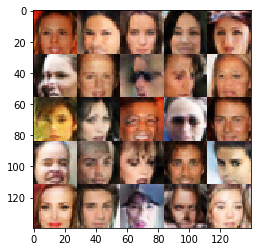

Epoch 5/5... Discriminator Loss: 0.8675... Generator Loss: 1.0320
Epoch 5/5... Discriminator Loss: 0.8524... Generator Loss: 1.0782
Epoch 5/5... Discriminator Loss: 0.9741... Generator Loss: 0.8382
Epoch 5/5... Discriminator Loss: 1.4574... Generator Loss: 0.5210
Epoch 5/5... Discriminator Loss: 1.0449... Generator Loss: 0.9086
Epoch 5/5... Discriminator Loss: 0.8479... Generator Loss: 1.1326
Epoch 5/5... Discriminator Loss: 1.1644... Generator Loss: 0.7427
Epoch 5/5... Discriminator Loss: 1.2930... Generator Loss: 0.6167
Epoch 5/5... Discriminator Loss: 0.7123... Generator Loss: 1.3216
Epoch 5/5... Discriminator Loss: 1.1696... Generator Loss: 0.6329


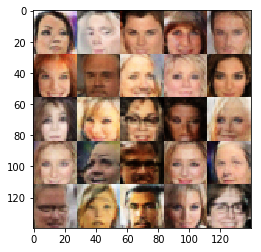

Epoch 5/5... Discriminator Loss: 0.8545... Generator Loss: 2.1998
Epoch 5/5... Discriminator Loss: 1.1433... Generator Loss: 0.7008
Epoch 5/5... Discriminator Loss: 1.3269... Generator Loss: 2.9092
Epoch 5/5... Discriminator Loss: 0.6298... Generator Loss: 1.6278
Epoch 5/5... Discriminator Loss: 0.8855... Generator Loss: 1.0278
Epoch 5/5... Discriminator Loss: 1.3605... Generator Loss: 0.5166
Epoch 5/5... Discriminator Loss: 1.0654... Generator Loss: 0.8590
Epoch 5/5... Discriminator Loss: 0.8752... Generator Loss: 1.4251
Epoch 5/5... Discriminator Loss: 1.1744... Generator Loss: 0.6503
Epoch 5/5... Discriminator Loss: 0.5929... Generator Loss: 1.8649


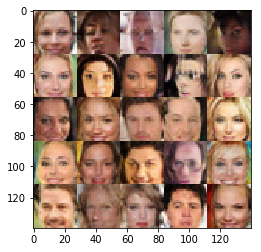

Epoch 5/5... Discriminator Loss: 1.0389... Generator Loss: 0.9605
Epoch 5/5... Discriminator Loss: 1.3161... Generator Loss: 0.8641
Epoch 5/5... Discriminator Loss: 0.7728... Generator Loss: 1.2960
Epoch 5/5... Discriminator Loss: 0.9794... Generator Loss: 1.1424
Epoch 5/5... Discriminator Loss: 0.9265... Generator Loss: 1.0343
Epoch 5/5... Discriminator Loss: 0.8152... Generator Loss: 1.1029
Epoch 5/5... Discriminator Loss: 0.7115... Generator Loss: 1.5289
Epoch 5/5... Discriminator Loss: 0.8011... Generator Loss: 1.7610
Epoch 5/5... Discriminator Loss: 1.0085... Generator Loss: 0.8474
Epoch 5/5... Discriminator Loss: 0.7379... Generator Loss: 1.3937


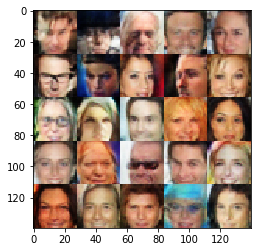

Epoch 5/5... Discriminator Loss: 0.9740... Generator Loss: 1.2084
Epoch 5/5... Discriminator Loss: 0.5924... Generator Loss: 1.9180
Epoch 5/5... Discriminator Loss: 1.0092... Generator Loss: 1.3246
Epoch 5/5... Discriminator Loss: 1.0412... Generator Loss: 1.6810
Epoch 5/5... Discriminator Loss: 0.9333... Generator Loss: 0.9843
Epoch 5/5... Discriminator Loss: 0.8951... Generator Loss: 1.2514
Epoch 5/5... Discriminator Loss: 1.7059... Generator Loss: 0.3367
Epoch 5/5... Discriminator Loss: 0.9136... Generator Loss: 0.9334
Epoch 5/5... Discriminator Loss: 1.1923... Generator Loss: 0.7473
Epoch 5/5... Discriminator Loss: 0.8721... Generator Loss: 1.0536


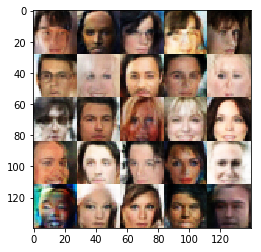

Epoch 5/5... Discriminator Loss: 1.0562... Generator Loss: 0.8271
Epoch 5/5... Discriminator Loss: 1.4037... Generator Loss: 0.5483
Epoch 5/5... Discriminator Loss: 1.0941... Generator Loss: 0.8512
Epoch 5/5... Discriminator Loss: 0.8703... Generator Loss: 1.6754
Epoch 5/5... Discriminator Loss: 1.0796... Generator Loss: 0.7725
Epoch 5/5... Discriminator Loss: 1.5849... Generator Loss: 0.4029
Epoch 5/5... Discriminator Loss: 1.6610... Generator Loss: 0.3711
Epoch 5/5... Discriminator Loss: 1.5501... Generator Loss: 0.4303
Epoch 5/5... Discriminator Loss: 1.1094... Generator Loss: 0.7550
Epoch 5/5... Discriminator Loss: 1.5757... Generator Loss: 0.4183


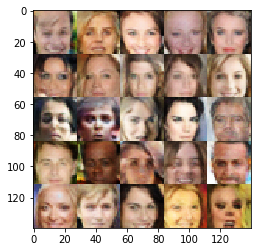

Epoch 5/5... Discriminator Loss: 0.5421... Generator Loss: 2.1312
Epoch 5/5... Discriminator Loss: 0.5977... Generator Loss: 1.8379
Epoch 5/5... Discriminator Loss: 0.5580... Generator Loss: 1.9025


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0009
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.